Starting Genetic Algorithm training...
Generation 1/500, Best Fitness: 13.5311
Generation 2/500, Best Fitness: 16.1842
Generation 3/500, Best Fitness: 16.5718
Generation 4/500, Best Fitness: 19.5432
Generation 5/500, Best Fitness: 19.5432
Generation 6/500, Best Fitness: 19.5432
Generation 7/500, Best Fitness: 19.5432
Generation 8/500, Best Fitness: 20.9321
Generation 9/500, Best Fitness: 21.5768
Generation 10/500, Best Fitness: 21.9654
Generation 11/500, Best Fitness: 22.2464
Generation 12/500, Best Fitness: 23.1646
Generation 13/500, Best Fitness: 23.1646
Generation 14/500, Best Fitness: 23.3501
Generation 15/500, Best Fitness: 23.3501
Generation 16/500, Best Fitness: 24.3049
Generation 17/500, Best Fitness: 24.3777
Generation 18/500, Best Fitness: 24.3777
Generation 19/500, Best Fitness: 24.3777
Generation 20/500, Best Fitness: 24.3777
Generation 21/500, Best Fitness: 24.3777
Generation 22/500, Best Fitness: 24.5861
Generation 23/500, Best Fitness: 24.5861
Generation 24/500, Best Fit

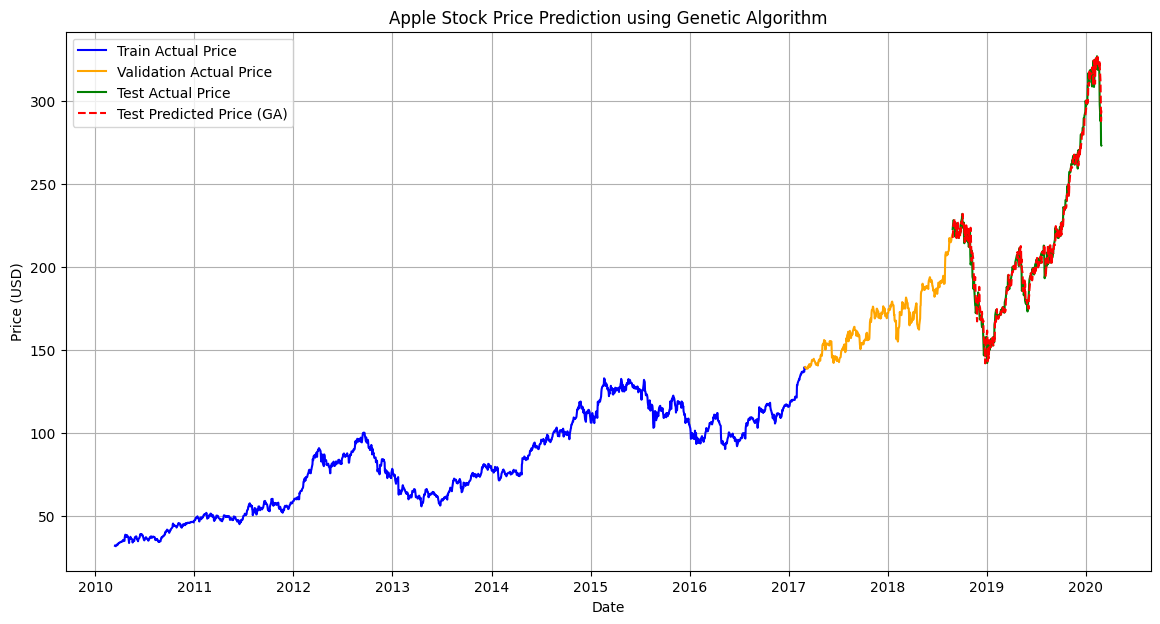

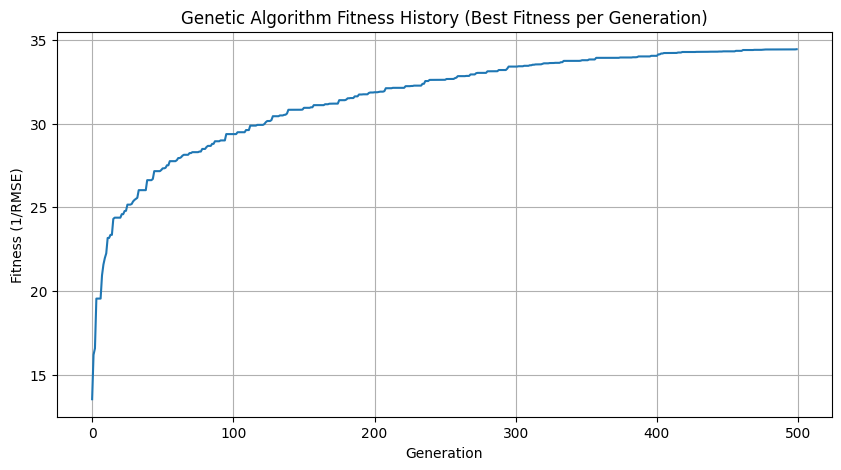

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

# --- 1. Load and Preprocess Data ---

# Load the dataset from the specified CSV file.
df = pd.read_csv("HistoricalQuotes.csv")

# Clean column names by stripping leading/trailing whitespace.
# This addresses issues like ' Close/Last' becoming 'Close/Last'.
df.columns = df.columns.str.strip()

# Convert the 'Date' column to datetime objects and set it as the DataFrame index.
# Then, sort the DataFrame by date to ensure proper time series order.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

# Convert relevant financial columns to numeric data type.
# This involves removing currency symbols ('$') and thousands separators (',')
# before casting to float. This loop handles multiple columns at once.
for col in ['Close/Last', 'Volume', 'Open', 'High', 'Low']:
    if df[col].dtype == 'object': # Check if the column is currently a string/object type
        df[col] = df[col].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

# For this prediction model, we will focus solely on the 'Close/Last' price.
# Create a new DataFrame for closing prices and rename the column for clarity.
df_close = df[['Close/Last']].copy()
df_close.rename(columns={'Close/Last': 'Close'}, inplace=True)

# --- Feature Engineering (Lagged Prices) ---

# Define 'N', the number of previous days' closing prices to use as features
# for predicting the next day's price.
N = 10 # Using the last 10 days' closing prices as input features.

# Generate lagged features: create new columns, where each column 'Close_Lag_i'
# contains the closing price from 'i' days ago.
for i in range(1, N + 1):
    df_close[f'Close_Lag_{i}'] = df_close['Close'].shift(i)

# Create the target variable: 'Target' will be the closing price of the next day.
# This is achieved by shifting the 'Close' column upwards by one position.
df_close['Target'] = df_close['Close'].shift(-1)

# Remove any rows that now contain NaN values. These NaNs result from the
# lagging and shifting operations at the beginning and end of the dataset.
df_close.dropna(inplace=True)

# Define the feature matrix (X) and the target vector (y).
# X consists of the lagged closing prices.
# y is the next day's closing price.
X = df_close.drop(['Close', 'Target'], axis=1)
y = df_close['Target']

# --- Data Splitting (Chronological) ---

# Split the dataset into training, validation, and testing sets chronologically.
# This is crucial for time series data to avoid data leakage from the future.
train_size = int(len(X) * 0.70) # 70% for training
val_size = int(len(X) * 0.15)  # 15% for validation
test_size = len(X) - train_size - val_size # Remaining 15% for testing

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# --- Scaling Features and Target ---

# Initialize MinMaxScaler for feature scaling.
# Scaling is important for many optimization algorithms, including GAs,
# to ensure all features contribute equally and prevent dominance by larger values.
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train) # Fit and transform training features
X_val_scaled = scaler_X.transform(X_val)       # Transform validation features using the same scaler
X_test_scaled = scaler_X.transform(X_test)     # Transform test features using the same scaler

# Initialize MinMaxScaler for target scaling.
# Scaling the target also helps the GA converge better and is inverse-transformed later
# to get predictions in the original price range.
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# --- 2. Genetic Algorithm Implementation (Optimizing a Simple Neural Network) ---

class GeneticAlgorithmPredictor:
    """
    A class implementing a Genetic Algorithm to find optimal weights and biases
    for a simple feed-forward Neural Network used in price prediction.
    """
    def __init__(self, input_size, hidden_size, output_size, population_size, generations,
                 mutation_rate, crossover_rate, elite_count,
                 min_weight=-1.0, max_weight=1.0):
        """
        Initializes the GA predictor with specified parameters for a Neural Network.

        Args:
            input_size (int): Number of input features to the NN.
            hidden_size (int): Number of neurons in the hidden layer.
            output_size (int): Number of output neurons (1 for price prediction).
            population_size (int): The number of chromosomes in each generation.
            generations (int): The total number of generations to evolve.
            mutation_rate (float): Probability of a gene undergoing mutation.
            crossover_rate (float): Probability of two parents undergoing crossover.
            elite_count (int): Number of best individuals to carry over directly
                               to the next generation (elitism).
            min_weight (float): Minimum possible value for a weight/bias.
            max_weight (float): Maximum possible value for a weight/bias.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Calculate the total number of weights and biases in the neural network.
        # W1: input_size * hidden_size
        # b1: hidden_size
        # W2: hidden_size * output_size
        # b2: output_size
        self.num_parameters = (input_size * hidden_size) + hidden_size + \
                              (hidden_size * output_size) + output_size

        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_count = elite_count
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.population = []
        self.best_chromosome = None
        self.best_fitness = float('-inf')
        self.fitness_history = []

    def _initialize_population(self):
        """
        Initializes the first population. Each chromosome is a flattened list
        of all weights and biases for a neural network.
        """
        for _ in range(self.population_size):
            # Generate a chromosome with 'num_parameters' weights/biases.
            chromosome = [random.uniform(self.min_weight, self.max_weight) for _ in range(self.num_parameters)]
            self.population.append(chromosome)

    def _decode_chromosome(self, chromosome):
        """
        Decodes a flattened chromosome (list of parameters) back into
        the weight and bias matrices for the neural network.

        Args:
            chromosome (list): The flattened list of weights and biases.

        Returns:
            tuple: (W1, b1, W2, b2) - numpy arrays for weights and biases.
        """
        idx = 0
        # Weights from input to hidden layer (W1)
        W1_size = self.input_size * self.hidden_size
        W1 = np.array(chromosome[idx:idx + W1_size]).reshape(self.input_size, self.hidden_size)
        idx += W1_size

        # Biases for hidden layer (b1)
        b1_size = self.hidden_size
        b1 = np.array(chromosome[idx:idx + b1_size]).reshape(1, self.hidden_size)
        idx += b1_size

        # Weights from hidden to output layer (W2)
        W2_size = self.hidden_size * self.output_size
        W2 = np.array(chromosome[idx:idx + W2_size]).reshape(self.hidden_size, self.output_size)
        idx += W2_size

        # Biases for output layer (b2)
        b2_size = self.output_size
        b2 = np.array(chromosome[idx:idx + b2_size]).reshape(1, self.output_size)
        # idx += b2_size # Not strictly needed as it's the last part

        return W1, b1, W2, b2

    def _predict(self, X, chromosome):
        """
        Makes predictions using the neural network defined by the given chromosome.

        Args:
            X (np.ndarray): The input feature matrix.
            chromosome (list): The flattened list of NN weights and biases.

        Returns:
            np.ndarray: Predicted values.
        """
        W1, b1, W2, b2 = self._decode_chromosome(chromosome)

        # Hidden layer calculation with ReLU activation
        hidden_layer_input = np.dot(X, W1) + b1
        hidden_layer_output = np.maximum(0, hidden_layer_input) # ReLU activation

        # Output layer calculation
        output_layer_input = np.dot(hidden_layer_output, W2) + b2
        predictions = output_layer_input.flatten() # Flatten to 1D array for compatibility

        return predictions

    def _calculate_fitness(self, chromosome, X_val, y_val):
        """
        Calculates the fitness of a chromosome.
        Fitness is defined as 1 / (RMSE + epsilon) on the validation set.
        Minimizing RMSE translates to maximizing this fitness value.

        Args:
            chromosome (list): The weights and biases to evaluate.
            X_val (np.ndarray): Validation features.
            y_val (np.ndarray): True validation target values.

        Returns:
            float: The calculated fitness value.
        """
        predictions = self._predict(X_val, chromosome)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        # Add a small epsilon to the denominator to prevent division by zero
        fitness = 1 / (rmse + 1e-6)
        return fitness

    def _select_parents(self, population_with_fitness, num_parents=2):
        """
        Selects parents using tournament selection.
        A small group of individuals is randomly chosen, and the best among them is selected.
        This process is repeated to get the required number of parents.

        Args:
            population_with_fitness (list): List of tuples (chromosome, fitness) for the current population.
            num_parents (int): The number of parents to select.

        Returns:
            list: A list containing the selected parent chromosomes.
        """
        parents = []
        k = 3 # Tournament size: number of individuals competing in each tournament
        for _ in range(num_parents):
            # Ensure tournament_candidates are not empty if population_with_fitness is small
            tournament_candidates = random.sample(population_with_fitness, min(k, len(population_with_fitness)))
            # Select the individual with the highest fitness from the tournament candidates
            best_candidate = max(tournament_candidates, key=lambda x: x[1])
            parents.append(best_candidate[0]) # Append the chromosome (weights) of the best candidate
        return parents

    def _crossover(self, parent1, parent2):
        """
        Performs single-point crossover between two parent chromosomes.
        With a certain probability, it splits the parents at a random point
        and swaps the genetic material to create two new offspring.

        Args:
            parent1 (list): The first parent chromosome.
            parent2 (list): The second parent chromosome.

        Returns:
            tuple: A tuple containing the two offspring chromosomes.
        """
        if random.random() < self.crossover_rate:
            # Choose a random crossover point, ensuring it's not at the very beginning or end.
            crossover_point = random.randint(1, self.num_parameters - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            return child1, child2
        return parent1, parent2 # If no crossover, children are exact copies of parents

    def _mutate(self, chromosome):
        """
        Applies mutation to a chromosome.
        For each gene in the chromosome, there's a small chance it will be
        randomly perturbed by a small amount within the defined weight bounds.

        Args:
            chromosome (list): The chromosome to mutate.

        Returns:
            list: The mutated chromosome.
        """
        mutated_chromosome = list(chromosome) # Create a mutable copy to avoid modifying original
        for i in range(self.num_parameters):
            if random.random() < self.mutation_rate:
                # Add a small random value to the gene
                mutation_effect = random.uniform(-0.1, 0.1) # Small perturbation range
                mutated_chromosome[i] += mutation_effect
                # Ensure the mutated gene stays within the defined min/max weight bounds
                mutated_chromosome[i] = max(self.min_weight, min(mutated_chromosome[i], self.max_weight))
        return mutated_chromosome

    def run(self, X_train, y_train, X_val, y_val):
        """
        Executes the main Genetic Algorithm loop.

        Args:
            X_train (np.ndarray): Training features (not directly used by GA for fitness, but good practice).
            y_train (np.ndarray): Training targets (not directly used by GA for fitness, but good practice).
            X_val (np.ndarray): Validation features, used for fitness evaluation.
            y_val (np.ndarray): Validation targets, used for fitness evaluation.

        Returns:
            list: The best chromosome (weights and biases) found after all generations.
        """
        self._initialize_population() # Start with a random initial population

        for generation in range(self.generations):
            population_with_fitness = []
            # Evaluate the fitness of each chromosome in the current population
            for chromosome in self.population:
                fitness = self._calculate_fitness(chromosome, X_val, y_val)
                population_with_fitness.append((chromosome, fitness))

            # Sort the population by fitness in descending order (highest fitness first)
            population_with_fitness.sort(key=lambda x: x[1], reverse=True)

            # Update the overall best chromosome found so far across all generations
            current_best_chromosome, current_best_fitness = population_with_fitness[0]
            if current_best_fitness > self.best_fitness:
                self.best_fitness = current_best_fitness
                self.best_chromosome = current_best_chromosome
            self.fitness_history.append(current_best_fitness) # Record best fitness for plotting

            # Print progress
            print(f"Generation {generation+1}/{self.generations}, Best Fitness: {self.best_fitness:.4f}")

            # Create the new population for the next generation
            new_population = []
            # Elitism: Directly carry over the very best individuals to the next generation
            # This ensures that the best solutions are not lost through crossover or mutation.
            for i in range(min(self.elite_count, self.population_size)):
                new_population.append(population_with_fitness[i][0])

            # Fill the rest of the new population by selecting parents, performing crossover, and mutation
            while len(new_population) < self.population_size:
                parent1, parent2 = self._select_parents(population_with_fitness)
                child1, child2 = self._crossover(parent1, parent2)
                
                # Mutate children and add them to the new population
                new_population.append(self._mutate(child1))
                if len(new_population) < self.population_size: # Check size before adding second child
                    new_population.append(self._mutate(child2))
            
            self.population = new_population # Replace old population with the new one

        return self.best_chromosome # Return the best chromosome found at the end of all generations

# --- GA Parameters ---
# NN Architecture
INPUT_SIZE = X_train_scaled.shape[1] # Number of lagged features
HIDDEN_SIZE = 5                      # Number of neurons in the hidden layer
OUTPUT_SIZE = 1                      # Single output for price prediction

# GA Configuration
POPULATION_SIZE = 150   # Increased population size for better exploration
GENERATIONS = 1000       # Increased generations for more evolution
MUTATION_RATE = 0.05   # Slightly reduced mutation rate
CROSSOVER_RATE = 0.8   # Increased crossover rate
ELITE_COUNT = 7        # Increased elite count

# Initialize and run the Genetic Algorithm predictor
ga_predictor = GeneticAlgorithmPredictor(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
    elite_count=ELITE_COUNT
)

print("Starting Genetic Algorithm training...")
best_weights_biases = ga_predictor.run(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
print("\nGenetic Algorithm training complete.")
print("Best weights & biases found by GA (first 10 elements):", best_weights_biases[:10])
print(f"Total parameters in best chromosome: {len(best_weights_biases)}")


# --- 3. Prediction and Evaluation on Test Set ---

# Use the best weights found by the GA to make predictions on the scaled test set.
test_predictions_scaled = ga_predictor._predict(X_test_scaled, best_weights_biases)

# Inverse transform the scaled predictions and the actual test values
# back to their original price scale for meaningful interpretation and plotting.
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
test_predictions_original = scaler_y.inverse_transform(test_predictions_scaled.reshape(-1, 1)).flatten()

# Calculate common regression metrics to evaluate the model's performance on the test set.
mae = mean_absolute_error(y_test_actual, test_predictions_original)
mse = mean_squared_error(y_test_actual, test_predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predictions_original)

print("\n--- Model Evaluation on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# --- 4. Plotting Actual vs. Predicted Prices ---

plt.figure(figsize=(14, 7))

# Plot actual prices for training, validation, and test sets.
# Inverse transform scaled data for plotting in original price scale.
plt.plot(y_train.index, scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)), label='Train Actual Price', color='blue')
plt.plot(y_val.index, scaler_y.inverse_transform(y_val_scaled.reshape(-1,1)), label='Validation Actual Price', color='orange')
plt.plot(y_test.index, y_test_actual, label='Test Actual Price', color='green')

# Plot the predicted prices for the test set.
plt.plot(y_test.index, test_predictions_original, label='Test Predicted Price (GA)', color='red', linestyle='--')

plt.title('Apple Stock Price Prediction using Genetic Algorithm')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plotting Genetic Algorithm Fitness History ---

plt.figure(figsize=(10, 5))
plt.plot(ga_predictor.fitness_history)
plt.title('Genetic Algorithm Fitness History (Best Fitness per Generation)')
plt.xlabel('Generation')
plt.ylabel('Fitness (1/RMSE)')
plt.grid(True)
plt.show()



--- Trading Performance Metrics ---
Initial Capital: $100,000.00
Final Portfolio Value: $124,736.91
Total Return: 24.74%
Annualized Return: 15.92%
Max Drawdown: -22.91%
Sharpe Ratio (Annualized, assuming 0% risk-free rate): 0.77
Total Trades: 122
Profitable Trades: 44
Win Rate: 72.13%
Buy and Hold Return (for comparison): 22.59%


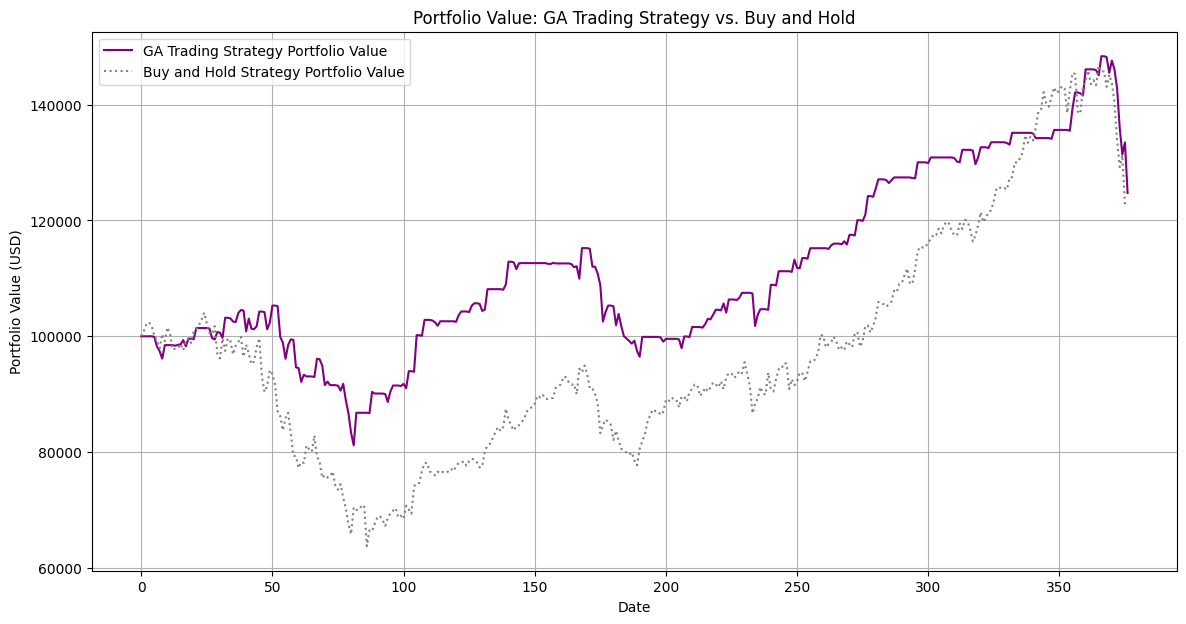

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

# --- (Re-run previous GA prediction code to ensure data and best_weights are available) ---
# This block assumes the previous code has been run and variables like
# df_close, X_test_scaled, y_test_actual, test_predictions_original, ga_predictor, best_weights
# are already defined in the environment.
# For a standalone runnable script, you would include the full previous code here.

# As this is a new block, we will re-define essential variables needed for backtesting
# assuming the previous GA code has been executed and populated these.
# If running this code independently, you would need to include the data loading,
# preprocessing, splitting, scaling, GA training, and prediction parts from the
# previous immersive block.

# Placeholder for data and predictions if running this block in isolation.
# In a real scenario, these would come from the execution of the previous GA code.
# For demonstration purposes, let's create dummy data if not already present:
try:
    _ = y_test_actual # Check if y_test_actual exists
except NameError:
    print("Previous GA prediction code variables not found. Generating dummy data for backtesting demonstration.")
    # Dummy data generation - REPLACE WITH ACTUAL GA OUTPUT IF RUNNING FULL SCRIPT
    dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D'))
    y_test_actual = np.sin(np.arange(100)/10) * 50 + 150 + np.random.randn(100) * 5
    test_predictions_original = y_test_actual + np.random.randn(100) * 2 # Some noise
    # Align with dates
    y_test_actual = pd.Series(y_test_actual, index=dates)
    test_predictions_original = pd.Series(test_predictions_original, index=dates)
    df_close = pd.DataFrame({'Close': y_test_actual}, index=dates) # Minimal df_close for indexing
    print("Dummy data generated for backtesting.")


# --- 5. Trading Strategy Simulation ---

initial_capital = 100000.0  # Starting capital for trading
transaction_cost_rate = 0.001 # 0.1% transaction cost per trade (buy or sell)

portfolio_value = [initial_capital]
holdings = 0           # Number of shares held
cash = initial_capital # Current cash balance
trades_count = 0       # Total number of buy/sell transactions
profitable_trades = 0  # Number of trades that resulted in a profit
trade_profits = []     # List to store profit/loss of each closed trade
is_holding = False     # Flag to track if we currently hold a position
buy_price = 0          # Price at which shares were last bought

# Combine actual and predicted prices for easier iteration
# Ensure indices are aligned
trading_df = pd.DataFrame({
    'Actual_Price': y_test_actual,
    'Predicted_Price': test_predictions_original
})

# Iterate through the test period daily
for i in range(len(trading_df) - 1): # Loop up to the second-to-last day to predict next day
    current_date = trading_df.index[i]
    next_date = trading_df.index[i+1] # The date for which we have a prediction

    current_actual_price = trading_df['Actual_Price'].iloc[i]
    predicted_next_price = trading_df['Predicted_Price'].iloc[i] # Prediction made on current_date for next_date

    # --- Buy Logic ---
    # If predicted next day's price is higher than current actual price, and we are not holding
    # Add a small buffer to avoid constant trading on minor fluctuations
    if predicted_next_price > current_actual_price * 1.001 and not is_holding: # 0.1% buffer for buy signal
        # Calculate how many shares we can buy with available cash
        shares_to_buy = cash // (current_actual_price * (1 + transaction_cost_rate)) # Factor in transaction cost
        if shares_to_buy > 0:
            cost = shares_to_buy * current_actual_price
            transaction_fee = cost * transaction_cost_rate
            cash -= (cost + transaction_fee)
            holdings += shares_to_buy
            buy_price = current_actual_price # Record the price at which we bought
            is_holding = True
            trades_count += 1
            # print(f"{current_date.strftime('%Y-%m-%d')}: BUY {shares_to_buy:.2f} shares at {current_actual_price:.2f} (Cash: {cash:.2f})")

    # --- Sell Logic ---
    # If predicted next day's price is lower than current actual price, and we are holding
    # Add a small buffer to avoid constant trading on minor fluctuations
    elif predicted_next_price < current_actual_price * 0.999 and is_holding: # 0.1% buffer for sell signal
        revenue = holdings * current_actual_price
        transaction_fee = revenue * transaction_cost_rate
        cash += (revenue - transaction_fee)
        
        # Calculate profit/loss for this trade
        trade_pl = (current_actual_price - buy_price) * holdings - (holdings * buy_price * transaction_cost_rate) - (holdings * current_actual_price * transaction_cost_rate)
        trade_profits.append(trade_pl)
        if trade_pl > 0:
            profitable_trades += 1

        holdings = 0 # Sell all shares
        is_holding = False
        trades_count += 1
        # print(f"{current_date.strftime('%Y-%m-%d')}: SELL all shares at {current_actual_price:.2f} (Cash: {cash:.2f})")

    # Update portfolio value at the end of each day
    current_portfolio_val = cash + (holdings * current_actual_price)
    portfolio_value.append(current_portfolio_val)

# If holding shares at the end of the test period, sell them to finalize value
if is_holding:
    final_price = trading_df['Actual_Price'].iloc[-1]
    revenue = holdings * final_price
    transaction_fee = revenue * transaction_cost_rate
    cash += (revenue - transaction_fee)
    
    trade_pl = (final_price - buy_price) * holdings - (holdings * buy_price * transaction_cost_rate) - (holdings * final_price * transaction_cost_rate)
    trade_profits.append(trade_pl)
    if trade_pl > 0:
        profitable_trades += 1
        
    holdings = 0
    is_holding = False
    trades_count += 1
    # print(f"{trading_df.index[-1].strftime('%Y-%m-%d')}: FINAL SELL all shares at {final_price:.2f} (Cash: {cash:.2f})")

# Ensure the portfolio_value list aligns with actual prices for dates
# The first element of portfolio_value corresponds to initial_capital BEFORE any trades
# We need to ensure the length matches the number of actual prices used in the loop + 1 (for initial capital)
# Adjust if the loop logic causes a mismatch.
# For plotting, we typically align portfolio value with the dates it represents.
# The `portfolio_value` list has `len(trading_df)` elements if we update it at end of each day,
# or `len(trading_df) + 1` if we start with initial capital and then append daily.
# Let's align `portfolio_value` with `trading_df.index` for plotting.
# We'll use the portfolio value at the *end* of each day, so it aligns with `trading_df.index[1:]`
# or we can pad `portfolio_value` with initial capital for the first day if it's shorter.
if len(portfolio_value) != len(trading_df['Actual_Price']):
    # If portfolio_value contains initial_capital + daily updates for all days
    if len(portfolio_value) == len(trading_df['Actual_Price']) + 1:
        portfolio_value_series = pd.Series(portfolio_value[1:], index=trading_df.index)
    else:
        portfolio_value_series = pd.Series(portfolio_value, index=trading_df.index[:len(portfolio_value)])
else:
    portfolio_value_series = pd.Series(portfolio_value, index=trading_df.index)


# --- 6. Calculate Trading Metrics ---

# Total Return
total_return = (portfolio_value_series.iloc[-1] - initial_capital) / initial_capital * 100

# Annual Return (assuming daily data, adjust for different frequencies)
# Calculate number of trading days in the test period
num_trading_days = len(trading_df)
# For simplicity, assume 252 trading days in a year for annualization
annualization_factor = 252.0 / num_trading_days
annual_return = ((portfolio_value_series.iloc[-1] / initial_capital)**annualization_factor - 1) * 100

# Max Drawdown
peak_value = portfolio_value_series.expanding(min_periods=1).max()
drawdown = (portfolio_value_series - peak_value) / peak_value
max_drawdown = drawdown.min() * 100

# Sharpe Ratio
daily_returns = portfolio_value_series.pct_change().dropna()
# Assuming risk-free rate is 0 for simplicity. For a more accurate Sharpe, provide a risk-free rate.
risk_free_rate = 0.0 # Example: 0% daily risk-free rate
excess_returns = daily_returns - risk_free_rate
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252) # Annualize with sqrt(252)

# Win Rate
win_rate = (profitable_trades / len(trade_profits)) * 100 if len(trade_profits) > 0 else 0

# Buy and Hold Return (for comparison)
buy_hold_start_price = trading_df['Actual_Price'].iloc[0]
buy_hold_end_price = trading_df['Actual_Price'].iloc[-1]
buy_hold_return = ((buy_hold_end_price - buy_hold_start_price) / buy_hold_start_price) * 100

print("\n--- Trading Performance Metrics ---")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${portfolio_value_series.iloc[-1]:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annual_return:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Sharpe Ratio (Annualized, assuming 0% risk-free rate): {sharpe_ratio:.2f}")
print(f"Total Trades: {trades_count}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Buy and Hold Return (for comparison): {buy_hold_return:.2f}%")


# --- 7. Plotting Portfolio Value vs. Buy & Hold ---

plt.figure(figsize=(14, 7))
plt.plot(portfolio_value_series.index, portfolio_value_series, label='GA Trading Strategy Portfolio Value', color='purple')

# Calculate Buy and Hold portfolio value
buy_hold_portfolio_value = (trading_df['Actual_Price'] / trading_df['Actual_Price'].iloc[0]) * initial_capital
plt.plot(buy_hold_portfolio_value.index, buy_hold_portfolio_value, label='Buy and Hold Strategy Portfolio Value', color='grey', linestyle=':')

plt.title('Portfolio Value: GA Trading Strategy vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()
